## Logistic Regression Implementation on (scaled) Reduced Dataset with LDA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data) and reduced dataset

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_LDA.csv', names=['Data'])
X_train.head()

,Data
0,-1.257048
1,1.264925
2,-0.447008
3,-1.603004
4,1.306823


Read Test Data

In [5]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_LDA.csv', names=['Data'])
X_test.head()

,Data
0,-0.558286
1,-0.018074
2,0.140791
3,-1.844159
4,-0.044481


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [6]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [7]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [8]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [9]:
predictions = model.predict(X_test)

Metrics for LR-LDA-untuned:
Accuracy: 0.7435
Weighted F1: 0.7433
Weighted Precision: 0.7436
Weighted Recall: 0.7435
Macro-Averaged Precision: 0.7437
Macro-Averaged Recall: 0.7428
F1: [0.75462078 0.73133287]
Precision: [0.74046279 0.74697078]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.77      0.75      1539
     Class 1       0.75      0.72      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


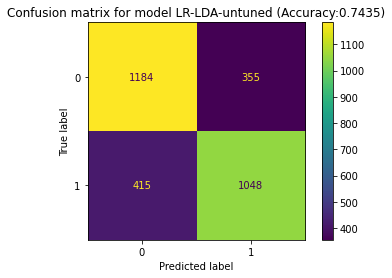

In [10]:
model_metrics = calculate_metrics('LR-LDA-untuned', y_test, predictions)

In [11]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [12]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [13]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 0.1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7435043304463691


Results of best models Grid Search CV

In [14]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                               params  mean_test_score
62  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...         0.735777
82  {'C': 0.1, 'max_iter': 5000, 'penalty': 'l2', ...         0.735777
58  {'C': 0.1, 'max_iter': 10, 'penalty': 'l2', 's...         0.735777
66  {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', '...         0.735777
78  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...         0.735777


Metrics for LR-LDA_CV1_best:
Accuracy: 0.7435
Weighted F1: 0.7433
Weighted Precision: 0.7436
Weighted Recall: 0.7435
Macro-Averaged Precision: 0.7437
Macro-Averaged Recall: 0.7428
F1: [0.75462078 0.73133287]
Precision: [0.74046279 0.74697078]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.77      0.75      1539
     Class 1       0.75      0.72      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


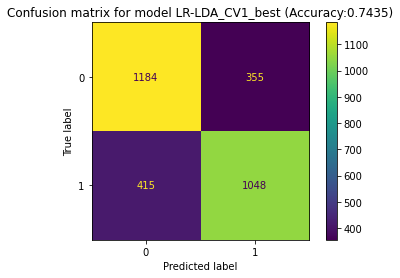

In [15]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-LDA_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [16]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Accuracy with Stratified K-Fold: 0.7425049966688874


Results of the best model 

In [17]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7425049966688874


Results of best models Grid Search CV

In [18]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
19   {'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...          0.73536
103  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'so...          0.73536
23   {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...          0.73536
91   {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'so...          0.73536
27   {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2'...          0.73536


Metrics for LR-LDA_skf_best:
Accuracy: 0.7425
Weighted F1: 0.7421
Weighted Precision: 0.7429
Weighted Recall: 0.7425
Macro-Averaged Precision: 0.7431
Macro-Averaged Recall: 0.7416
F1: [0.75545713 0.72810412]
Precision: [0.73612824 0.75      ]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1539
     Class 1       0.75      0.71      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


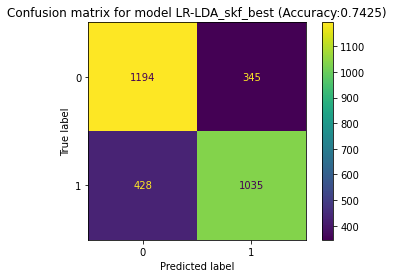

In [19]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-LDA_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [20]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [21]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 19:43:26,271] A new study created in memory with name: no-name-763c9ebb-52c9-462f-870d-c31d9614bba5
[I 2024-06-09 19:43:26,289] Trial 0 finished with value: 0.7435043304463691 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:26,314] Trial 1 finished with value: 0.7435043304463691 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:26,334] Trial 2 finished with value: 0.7435043304463691 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:26,355] Trial 3 finished with value: 0.7435043304463691 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7435043304463691.
[

Best Hyperparameters: {'penalty': 'l1', 'C': 0.01622977607749056, 'max_iter': 665, 'solver': 'liblinear'}
Best Accuracy: 0.7445036642238507


In [22]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
136,136,0.744504,2024-06-09 19:43:28.883836,2024-06-09 19:43:28.898858,0 days 00:00:00.015022,0.012556,827,l1,liblinear,COMPLETE
123,123,0.744504,2024-06-09 19:43:28.689881,2024-06-09 19:43:28.698886,0 days 00:00:00.009005,0.016230,665,l1,liblinear,COMPLETE
145,145,0.744504,2024-06-09 19:43:29.036833,2024-06-09 19:43:29.048831,0 days 00:00:00.011998,0.015937,297,l1,liblinear,COMPLETE
56,56,0.743837,2024-06-09 19:43:27.654920,2024-06-09 19:43:27.666878,0 days 00:00:00.011958,0.014025,177,l1,liblinear,COMPLETE
15,15,0.743837,2024-06-09 19:43:26.620931,2024-06-09 19:43:26.640937,0 days 00:00:00.020006,0.016725,642,l1,liblinear,COMPLETE
55,55,0.743837,2024-06-09 19:43:27.634918,2024-06-09 19:43:27.650895,0 days 00:00:00.015977,0.014073,510,l1,liblinear,COMPLETE
0,0,0.743504,2024-06-09 19:43:26.273930,2024-06-09 19:43:26.289931,0 days 00:00:00.016001,1.978697,354,l2,saga,COMPLETE
115,115,0.743504,2024-06-09 19:43:28.566875,2024-06-09 19:43:28.582885,0 days 00:00:00.016010,0.134040,346,l1,saga,COMPLETE
112,112,0.743504,2024-06-09 19:43:28.519859,2024-06-09 19:43:28.540855,0 days 00:00:00.020996,3.606649,416,l1,saga,COMPLETE
113,113,0.743504,2024-06-09 19:43:28.542882,2024-06-09 19:43:28.553845,0 days 00:00:00.010963,0.064088,408,l2,liblinear,COMPLETE


Metrics for LR-LDA_OPT1_best:
Accuracy: 0.7445
Weighted F1: 0.7441
Weighted Precision: 0.7450
Weighted Recall: 0.7445
Macro-Averaged Precision: 0.7452
Macro-Averaged Recall: 0.7436
F1: [0.75781497 0.72964399]
Precision: [0.73710074 0.75327511]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1539
     Class 1       0.75      0.71      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.75      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


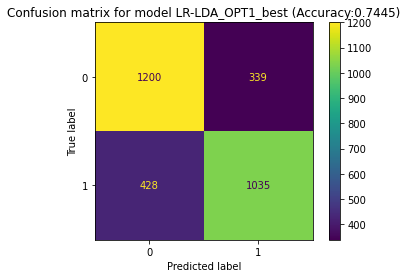

In [23]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR-LDA_OPT1_best', y_test, predictions_opt1)])

In [24]:
study.best_params

{'penalty': 'l1',
 'C': 0.01622977607749056,
 'max_iter': 665,
 'solver': 'liblinear'}

In [25]:
optuna.visualization.plot_optimization_history(study)

In [26]:
optuna.visualization.plot_parallel_coordinate(study)

In [27]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [28]:
optuna.visualization.plot_param_importances(study)

In [29]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [30]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [31]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 19:43:50,612] A new study created in memory with name: no-name-6fecdee9-119b-4d4c-9e2c-c867842636ee
[I 2024-06-09 19:43:50,635] Trial 0 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:50,661] Trial 1 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:50,696] Trial 2 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:43:50,722] Trial 3 finished with value: 0.7425049966688874 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7435043304463691


In [32]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.743504,2024-06-09 19:43:50.613822,2024-06-09 19:43:50.635820,0 days 00:00:00.021998,61.355064,0.517298,789,elasticnet,saga,COMPLETE
119,119,0.743504,2024-06-09 19:43:53.288722,2024-06-09 19:43:53.326722,0 days 00:00:00.038000,17.038859,0.219515,529,elasticnet,saga,COMPLETE
121,121,0.743504,2024-06-09 19:43:53.356718,2024-06-09 19:43:53.372768,0 days 00:00:00.016050,0.156149,0.677707,113,elasticnet,saga,COMPLETE
122,122,0.743504,2024-06-09 19:43:53.374758,2024-06-09 19:43:53.393722,0 days 00:00:00.018964,18.981897,0.599599,289,elasticnet,saga,COMPLETE
123,123,0.743504,2024-06-09 19:43:53.397727,2024-06-09 19:43:53.419748,0 days 00:00:00.022021,8.449974,0.633776,971,elasticnet,saga,COMPLETE
124,124,0.743504,2024-06-09 19:43:53.420731,2024-06-09 19:43:53.438747,0 days 00:00:00.018016,5.405927,0.087747,612,elasticnet,saga,COMPLETE
125,125,0.743504,2024-06-09 19:43:53.439751,2024-06-09 19:43:53.454741,0 days 00:00:00.014990,0.713634,0.169274,111,elasticnet,saga,COMPLETE
128,128,0.743504,2024-06-09 19:43:53.486745,2024-06-09 19:43:53.503748,0 days 00:00:00.017003,0.147543,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.743504,2024-06-09 19:43:53.504746,2024-06-09 19:43:53.522711,0 days 00:00:00.017965,0.561933,0.474294,114,elasticnet,saga,COMPLETE
130,130,0.743504,2024-06-09 19:43:53.523713,2024-06-09 19:43:53.539732,0 days 00:00:00.016019,10.892546,0.705562,345,elasticnet,saga,COMPLETE


Metrics for LR-LDA_OPT2_best:
Accuracy: 0.7435
Weighted F1: 0.7433
Weighted Precision: 0.7436
Weighted Recall: 0.7435
Macro-Averaged Precision: 0.7437
Macro-Averaged Recall: 0.7428
F1: [0.75462078 0.73133287]
Precision: [0.74046279 0.74697078]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.77      0.75      1539
     Class 1       0.75      0.72      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


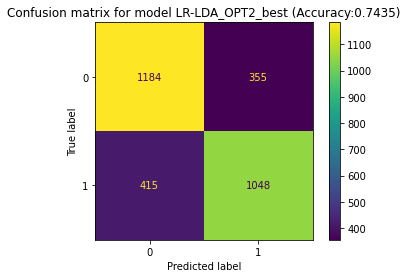

In [33]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-LDA_OPT2_best', y_test, predictions_opt2)])

In [34]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [35]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [36]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 19:44:05,403] A new study created in memory with name: no-name-1f655513-d5dc-47f4-9f28-c2209530f69d
[I 2024-06-09 19:44:05,426] Trial 0 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:44:05,450] Trial 1 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:44:05,482] Trial 2 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7435043304463691.
[I 2024-06-09 19:44:05,507] Trial 3 finished with value: 0.7435043304463691 and parameters: {'l1_ratio': 0.411

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7435043304463691


In [37]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.743504,2024-06-09 19:44:05.406776,2024-06-09 19:44:05.425799,0 days 00:00:00.019023,94.696791,0.517298,789,elasticnet,saga,COMPLETE
137,137,0.743504,2024-06-09 19:44:08.664653,2024-06-09 19:44:08.681646,0 days 00:00:00.016993,7.303382,0.494852,591,elasticnet,saga,COMPLETE
127,127,0.743504,2024-06-09 19:44:08.466673,2024-06-09 19:44:08.485684,0 days 00:00:00.019011,26.262630,0.535513,567,elasticnet,saga,COMPLETE
128,128,0.743504,2024-06-09 19:44:08.486682,2024-06-09 19:44:08.503648,0 days 00:00:00.016966,29.230015,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.743504,2024-06-09 19:44:08.504647,2024-06-09 19:44:08.525680,0 days 00:00:00.021033,43.747745,0.474294,114,elasticnet,saga,COMPLETE
130,130,0.743504,2024-06-09 19:44:08.527652,2024-06-09 19:44:08.545654,0 days 00:00:00.018002,75.930643,0.705562,345,elasticnet,saga,COMPLETE
131,131,0.743504,2024-06-09 19:44:08.546656,2024-06-09 19:44:08.564647,0 days 00:00:00.017991,72.450796,0.465636,174,elasticnet,saga,COMPLETE
132,132,0.743504,2024-06-09 19:44:08.565667,2024-06-09 19:44:08.584654,0 days 00:00:00.018987,72.067713,0.849127,992,elasticnet,saga,COMPLETE
133,133,0.743504,2024-06-09 19:44:08.585652,2024-06-09 19:44:08.602666,0 days 00:00:00.017014,25.327685,0.445845,244,elasticnet,saga,COMPLETE
134,134,0.743504,2024-06-09 19:44:08.604690,2024-06-09 19:44:08.619646,0 days 00:00:00.014956,68.777096,0.870727,442,elasticnet,saga,COMPLETE


Metrics for LR-LDA_OPT3_best:
Accuracy: 0.7435
Weighted F1: 0.7433
Weighted Precision: 0.7436
Weighted Recall: 0.7435
Macro-Averaged Precision: 0.7437
Macro-Averaged Recall: 0.7428
F1: [0.75462078 0.73133287]
Precision: [0.74046279 0.74697078]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.77      0.75      1539
     Class 1       0.75      0.72      0.73      1463

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


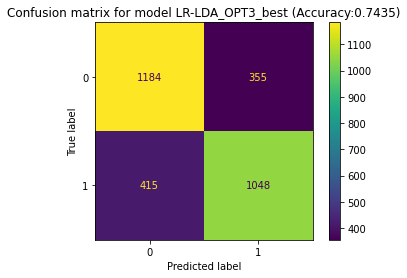

In [38]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR-LDA_OPT3_best', y_test, predictions_opt3)])

end

In [39]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR-LDA-untuned,0.743504,0.743272,0.743634,0.743504,0.743717,0.742834,[0.75462078 0.73133287],[0.74046279 0.74697078]
LR-LDA_CV1_best,0.743504,0.743272,0.743634,0.743504,0.743717,0.742834,[0.75462078 0.73133287],[0.74046279 0.74697078]
LR-LDA_skf_best,0.742505,0.742127,0.742889,0.742505,0.743064,0.741639,[0.75545713 0.72810412],[0.73612824 0.75 ]
LR-LDA_OPT1_best,0.744504,0.744086,0.744983,0.744504,0.745188,0.743589,[0.75781497 0.72964399],[0.73710074 0.75327511]
LR-LDA_OPT2_best,0.743504,0.743272,0.743634,0.743504,0.743717,0.742834,[0.75462078 0.73133287],[0.74046279 0.74697078]
LR-LDA_OPT3_best,0.743504,0.743272,0.743634,0.743504,0.743717,0.742834,[0.75462078 0.73133287],[0.74046279 0.74697078]
